eXplainable AI (XAI) -- 2022-2023
--------
&copy; Equipe pédagogique: Marie-Jeanne Lesot, Christophe Marsala


# Arbres de décision (catégoriel)

Quelques pistes pour l'implémentation

In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

### Base d'apprentissage jouet

In [2]:
# Chargement des fichiers de données :

elections_df = pd.read_csv("data/elections.csv")
elections_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [3]:
# Pour ne garder que le nom des variables de description (et pas la classe):
# sous la forme d'une liste:

elections_noms = [nom for nom in elections_df.columns if nom != 'Label']

# Passer du dataframe à des arrays:
elections_desc = np.array(elections_df[elections_noms])
elections_label = np.array(elections_df['Label'])

print("Noms des features: ",elections_noms)

Noms des features:  ['Adresse', 'Majeur?', 'Nationalite']


In [4]:
elections_label[elections_desc[:,0] == "Paris"]

array([ 1, -1, -1])

## Premières fonctions: entropie et classe majoritaire

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire</code> qui, étant donné un array de labels rend la classe majoritaire (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la première classe rencontrée.

**Remarque :** on utilise la fonction numpy `unique` qui permet d'obtenir les valeurs différentes d'un array ainsi que leur décompte.

In [5]:
# Exemple d'utilisation de la fonction numpy `unique`

valeurs, nb_fois = np.unique(elections_label,return_counts=True)

print("Valeurs différentes dans l'array           : ",valeurs)
print("Décompte de chaque valeur (respectivement) : ",nb_fois)

Valeurs différentes dans l'array           :  [-1  1]
Décompte de chaque valeur (respectivement) :  [5 3]


In [6]:
def classe_majoritaire(Y):
    """ Y : (array) : array de labels
        rend la classe majoritaire ()
    """
    #### A compléter pour répondre à la question posée

In [8]:
#Vérification sur nos données:
classe_majoritaire(elections_label)

-1

### Entropie et gain d'information


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `shannon` qui, étant donné une distribution de probabilités $P$ fournie sous la forme d'une liste de nombres, rend la valeur de $H_S(P)$, l'entropie de Shannon de $P$.

In [9]:
import math
def shannon(P):
    """ list[Number] -> float
        Hypothèse: la somme des nombres de P vaut 1
        P correspond à une distribution de probabilité
        rend la valeur de l'entropie de Shannon correspondante
        rem: la fonction utilise le log dont la base correspond à la taille de P
    """
    #### A compléter pour répondre à la question posée

In [11]:
# Exemples d'utilisation:
print("H([1]) = ", shannon([1]))
print("H([1,0]) = ", shannon([1, 0]))
print("H([0.25, 0.25, 0.25, 0.25]) = ", shannon([0.25, 0.25, 0.25, 0.25]))
print("H([0.7, 0.1, 0.2, 0.0]) = ", shannon([0.7, 0.1, 0.2, 0.0]))
print("H([1.0/3, 2.0/3]) = ", shannon([1.0/3, 2.0/3]))

H([1]) =  0.0
H([1,0]) =  0.0
H([0.25, 0.25, 0.25, 0.25]) =  1.0
H([0.7, 0.1, 0.2, 0.0]) =  0.5783898247235197
H([1.0/3, 2.0/3]) =  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon</code>, écrire la fonction <code>entropie</code> qui prend un ensemble de labels en argument et renvoie l'entropie de la distribution des classes dans cet ensemble.

In [12]:
def entropie(Y):
    """ Y : (array) : ensemble de labels de classe
        rend l'entropie de l'ensemble Y
    """
    #### A compléter pour répondre à la question posée

In [13]:
# Exemple sur nos données :
entropie(elections_label)

0.9544340029249649

## Arbres de décision


### Représentation d'un arbre en Python

Pour représenter un arbre en Python, on a besoin de définir une structure de données adéquate. 

Un arbre de décision est défini par des **noeuds** qui sont de 2 types :
- *noeud interne* : c'est un noeud qui est associé à un attribut (ie. une feature de description des exemples) et qui possède des fils qui sont aussi des noeuds. 
- *feuille* : c'est un noeud qui est associé à un label de la classe et qui a la particularité de ne pas avoir de descendants.

Pour représenter des noeuds, nous définissons la classe `NoeudCategoriel` suivante:

In [14]:
# Avant cela, la librairie suivante est nécessaire pour l'affichage graphique de l'arbre:
import graphviz as gv

# Eventuellement, vous devez installer cette librairie avec pip (ou pip3 selon votre config)
# pip3 install -U graphviz

In [15]:
# La librairie suivante est nécessaire pour l'affichage graphique de l'arbre:
import graphviz as gv

# Pour plus de détails : https://graphviz.readthedocs.io/en/stable/manual.html

# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz

class NoeudCategoriel:
    """ Classe pour représenter des noeuds d'un arbre de décision
    """
    def __init__(self, num_att=-1, nom=''):
        """ Constructeur: il prend en argument
            - num_att (int) : le numéro de l'attribut auquel il se rapporte: de 0 à ...
              si le noeud se rapporte à la classe, le numéro est -1, on n'a pas besoin
              de le préciser
            - nom (str) : une chaîne de caractères donnant le nom de l'attribut si
              il est connu (sinon, on ne met rien et le nom sera donné de façon 
              générique: "att_Numéro")
        """
        self.attribut = num_att    # numéro de l'attribut
        if (nom == ''):            # son nom si connu
            self.nom_attribut = 'att_'+str(num_att)
        else:
            self.nom_attribut = nom 
        self.Les_fils = None       # aucun fils à la création, ils seront ajoutés
        self.classe   = None       # valeur de la classe si c'est une feuille
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille 
            c'est une feuille s'il n'a aucun fils
        """
        return self.Les_fils == None
    
    def ajoute_fils(self, valeur, Fils):
        """ valeur : valeur de l'attribut de ce noeud qui doit être associée à Fils
                     le type de cette valeur dépend de la base
            Fils (NoeudCategoriel) : un nouveau fils pour ce noeud
            Les fils sont stockés sous la forme d'un dictionnaire:
            Dictionnaire {valeur_attribut : NoeudCategoriel}
        """
        if self.Les_fils == None:
            self.Les_fils = dict()
        self.Les_fils[valeur] = Fils
        # Rem: attention, on ne fait aucun contrôle, la nouvelle association peut
        # écraser une association existante.
    
    def ajoute_feuille(self,classe):
        """ classe: valeur de la classe
            Ce noeud devient un noeud feuille
        """
        self.classe    = classe
        self.Les_fils  = None   # normalement, pas obligatoire ici, c'est pour être sûr
        
    def predict(self, exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple (pour nous, soit +1, soit -1 en général)
            on rend la valeur 0 si l'exemple ne peut pas être classé (cf. les questions
            posées en fin de ce notebook)
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] in self.Les_fils:
            # descente récursive dans le noeud associé à la valeur de l'attribut
            # pour cet exemple:
            return self.Les_fils[exemple[self.attribut]].predict(exemple)
        else:
            # Cas particulier : on ne trouve pas la valeur de l'exemple dans la liste des
            # fils du noeud... Voir la fin de ce notebook pour essayer de résoudre ce mystère...
            print('\t*** Warning: attribut ',self.nom_attribut,' -> Valeur inconnue: ',exemple[self.attribut])
            return 0
    
    def predict_xai(self, exemple):
        ### A IMPLEMENTER
        pass
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir l'afficher graphiquement
            Cette fonction ne nous intéressera pas plus que ça, elle ne sera donc pas expliquée            
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, self.nom_attribut)
            i =0
            for (valeur, sous_arbre) in self.Les_fils.items():
                sous_arbre.to_graph(g,prefixe+str(i))
                g.edge(prefixe,prefixe+str(i), valeur)
                i = i+1        
        return g


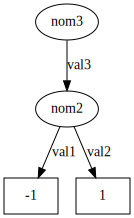

In [16]:
# Exemple d'utilisation: 
un_noeud0= NoeudCategoriel() 
un_noeud0.ajoute_feuille(-1)

un_noeud1= NoeudCategoriel()
un_noeud1.ajoute_feuille(+1)

un_noeud2= NoeudCategoriel(0,"nom2")
un_noeud2.ajoute_fils("val1",un_noeud0)
un_noeud2.ajoute_fils("val2",un_noeud1)

un_noeud3 = NoeudCategoriel(1,"nom3")
un_noeud3.ajoute_fils("val3",un_noeud2)

# L'affichage se fait en 2 temps
# 1) on initialise un graphe orienté :
gtree = gv.Digraph(format='png')
# 2) on le rempli en appelant la méthode de la classe NoeudCategoriel
un_noeud3.to_graph(gtree)

### Construction de l'arbre de décision

<font color="RED" size="+1">**[Q]**</font> Compléter la fonction `construit_AD`suivante afin qu'elle permette de construire un arbre de décision. Cette fonction rend un `NoeudCategoriel` qui correspond à l'arbre construit pour le dataset $(X,Y)$ donné.

In [18]:
def construit_AD(X,Y,epsilon,LNoms = []):
    """ X,Y : dataset
        epsilon : seuil d'entropie pour le critère d'arrêt 
        LNoms : liste des noms de features (colonnes) de description 
    """
    
    entropie_ens = entropie(Y)
    if (entropie_ens <= epsilon):
        # ARRET : on crée une feuille
        noeud = NoeudCategoriel(-1,"Label")
        noeud.ajoute_feuille(classe_majoritaire(Y))
    else:
        min_entropie = 1.1
        i_best = -1
        Xbest_valeurs = None
        
        #############
        
        # COMPLETER CETTE PARTIE : ELLE DOIT PERMETTRE D'OBTENIR DANS
        # i_best : le numéro de l'attribut qui minimise l'entropie
        # min_entropie : la valeur de l'entropie minimale
        # Xbest_valeurs : la liste des valeurs que peut prendre l'attribut i_best
        #
        # Il est donc nécessaire ici de parcourir tous les attributs et de calculer
        # la valeur de l'entropie de la classe pour chaque attribut.
        
        ## COMPLETER ICI !
        
        ############
        
        if len(LNoms)>0:  # si on a des noms de features
            noeud = NoeudCategoriel(i_best,LNoms[i_best])    
        else:
            noeud = NoeudCategoriel(i_best)
        for v in Xbest_valeurs:
            noeud.ajoute_fils(v,construit_AD(X[X[:,i_best]==v], Y[X[:,i_best]==v],epsilon,LNoms))
    return noeud

La classe pour implémenter un arbre de décision dérive de la classe `Classifier`. Elle utilise la fonction `construit_AD` dans sa méthode `train` pour construire un arbre à partir d'un dataset donné.

<font color="RED" size="+1">**[Q]**</font> Compléter la classe suivante en donnant le code des méthodes `train` et `predict`.

**Remarque :** la méthode `score` ne fera rien dans notre cas, on verra dans un autre notebook comment on pourrait la définir.

In [19]:
class ClassifierArbreDecision():
    """ Classe pour représenter un classifieur par arbre de décision
    """
    
    def __init__(self, input_dimension, epsilon, LNoms=[]):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        self.epsilon = epsilon
        self.LNoms = LNoms
        # l'arbre est manipulé par sa racine qui sera un Noeud
        self.racine = None
        
    def toString(self):
        """  -> str
            rend le nom du classifieur avec ses paramètres
        """
        return 'ClassifierArbreDecision ['+str(self.dimension) + '] eps='+str(self.epsilon)
        
    def fit(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        ##################
        ## COMPLETER ICI !
        ##################
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        ##################
        ## COMPLETER ICI !
        ##################

    def predict_xai(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x et le chemin suivi            
        """
        ##################
        ## COMPLETER ICI !
        ##################

    def affiche(self,GTree):
        """ affichage de l'arbre sous forme graphique
            Cette fonction modifie GTree par effet de bord
        """
        self.racine.to_graph(GTree)

### Premières expérimentations

Apprentissage d'un arbre de décision avec la base sur les élections :

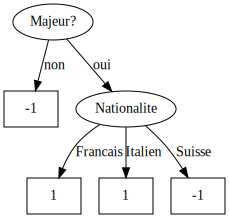

In [21]:
# Initialiation d'un arbre pour le dataset Elections:
arbre_elections = ClassifierArbreDecision(len(elections_noms), 0.0, elections_noms)

# Construction de l'arbre de décision à partir du dataset Elections
arbre_elections.fit(elections_desc,elections_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_elections = gv.Digraph(format='png')
arbre_elections.affiche(graphe_arbre_elections)

# Affichage du graphe obtenu:
graphe_arbre_elections

Pour classer un nouvel exemple avec un arbre de décision, on utilise la méthode <code>predict</code> qui utilise la méthode `classifie` de la classe `NoeudCategoriel` pour classer un nouvel exemple et renvoyer le label +1 ou -1 selon le cas. 

Exemple de classification d'un exemple avec l'arbre obtenu :

Classification d'un nouvel exemple qui n'appartient à pas au dataset d'apprentissage :

In [22]:
# Rappel : elections_noms = ['Adresse', 'Majeur?', 'Nationalite']
arbre_elections.predict(np.array(['Paris','oui','Italien']))

1

### Construction d'un arbre de décision avec la base Mushrooms


In [23]:
# Chargement des fichiers de données sur les mushrooms:

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")

# Noms des colonnes:
# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays):
mushrooms_1_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_1_label = np.array(mushrooms_df['class'])


On construit et on affiche l'arbre de décision correspondant.

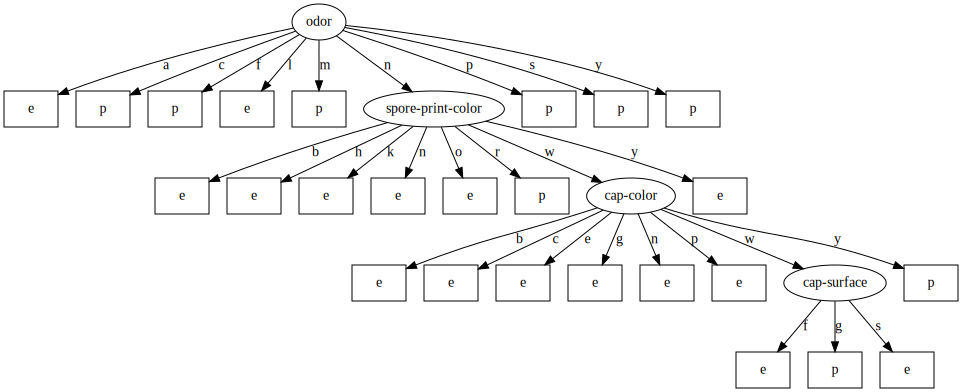

In [24]:
# construction de l'arbre de décision à partir du dataset Elections:
arbre_mushrooms_1 = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)

arbre_mushrooms_1.fit(mushrooms_1_desc,mushrooms_1_label)

# Construction de la représentation graphique (affichage)
gr_arbre_mushrooms_1 = gv.Digraph(format='png')
arbre_mushrooms_1.affiche(gr_arbre_mushrooms_1)

# Affichage du graphe obtenu:
gr_arbre_mushrooms_1

## Plus d'expérimentations avec la base Mushrooms

On décide maintenant d'évaluer plus en détail ce nouvel algorithme. On souhaite:
1. construire un arbre avec chaque fichier `mushrooms-1400-*.csv` 
2. pour chaque arbre construit, évaluer son accuracy:
    - sur le dataset d'apprentissage
    - sur les 4 autres fichiers `mushrooms-1400-*.csv`
    - sur le fichier `mushrooms-1124.csv`
    
    
**Remarque :** normalement, tous ces tests devraient pouvoir se faire dans un temps raisonnable, dans le cas contraire, faites les un par un.